# Mandatory Assignment 2: Supervised Learning

### Goals of the exercise
This exercise has three parts: 
* The goal of the first part is to get more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

* The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

* The third part, which is the smallest one, is dedicated to evaluation.

### Initialization

In [884]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [687]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [688]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [689]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [690]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

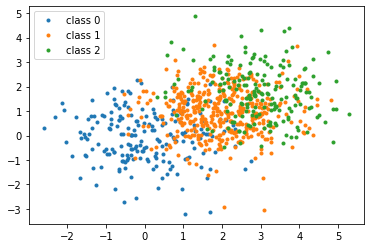

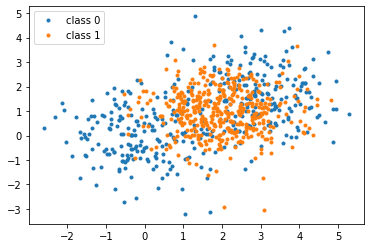

In [691]:
#Plotting the training sets 
def plotting(X, y, marker='.'):
    labels = set(y)
    for lab in labels:
        plt.plot(X[y == lab][:, 1], X[y == lab][:, 0],marker, label="class {}".format(lab))
    plt.legend()
    plt.show()

plotting(X_train,t_train)
plotting(X_train,t2_train)

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

We start by training the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. 

In [9]:
#function for adding the bias into the X
def add_bias(X):
    # Put bias in position 0
    sh = X.shape
    if len(sh) == 1:
        #X is a vector
        return np.concatenate([np.array([1]), X])
    else:
        # X is a matrix
        m = sh[0]
        bias = np.ones((m,1)) # Makes a m*1 matrix of 1-s
        return np.concatenate([bias, X], axis  = 1) 

def MSE(y,y_pred):
    return sum((y - y_pred)**2) /y.shape[0]

In [10]:
class NumpyClassifier():
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier
        using the predict method"""
        predictedValues = []
        for a in X_test:
            var = self.predict(a,**kwargs)
            predictedValues.append(var)
        equal = []
        for b,c in zip(predictedValues,y_test):
            if b == c:
                equal.append((b,c))
        accuracyVariable = len(equal)/len(y_test)
        return accuracyVariable

class LinRegClassifier(NumpyClassifier):
    def fit(self, X_train, t_train, eta = 0.1, epochs=10,diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""

        #Implementing the gradient descent:
        (N,m) = X_train.shape
        X_train = add_bias(X_train)
        self.weights = weights = np.zeros(m+1)
        
        #defining the update with a large number
        update = 100
        
        self.run = 0
        
        #the while loops goes on until the update is less than diff
        while update > diff:
            oldMSE = MSE(t_train,X_train @ weights)
            
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)
            
            newMSE = MSE(t_train,X_train @ weights)
            update = oldMSE - newMSE
            self.run += 1
        
        
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.weights
        return score>threshold

In [792]:
#training and validating the data
def runingLinReg(X_train,t2_train,X_val,t2_val,printing):
    print("Running the linear regression classifier")

    bestAcc_Lin = 0
    diffLin = 0
    for i in range(1,10,1):
        d = 1/10**(i)
        LinReg = LinRegClassifier()
        LinReg.fit(X_train,t2_train,diff=d)
        accuracy = LinReg.accuracy(X_val,t2_val)
        if printing == True:
            print(f'diff = {d:.9f} | accuracy = {accuracy:.5f} | runs = {LinReg.run}')

        if accuracy > bestAcc_Lin:
            bestAcc_Lin = accuracy
            diffLin = d

    return bestAcc_Lin,diffLin

bestAcc_Lin,diffLin = runingLinReg(X_train,t2_train,X_val,t2_val,True)
print(f"Best accuracy: {bestAcc_Lin:4.5f} with diff = {diffLin}")

Running the linear regression classifier
diff = 0.100000000 | accuracy = 0.47000 | runs = 2
diff = 0.010000000 | accuracy = 0.47750 | runs = 3
diff = 0.001000000 | accuracy = 0.51000 | runs = 19
diff = 0.000100000 | accuracy = 0.56000 | runs = 51
diff = 0.000010000 | accuracy = 0.58000 | runs = 83
diff = 0.000001000 | accuracy = 0.60000 | runs = 115
diff = 0.000000100 | accuracy = 0.60500 | runs = 148
diff = 0.000000010 | accuracy = 0.60750 | runs = 180
diff = 0.000000001 | accuracy = 0.60750 | runs = 212
Best accuracy: 0.60750 with diff = 1e-08


We can see from above that the *diff* variable is inversely proportional with the amount of runs the algorithm ran before it was terminated. Choosing the best diff is a tricky business since a small diff cause overfitting. However in this case the diff that gave the best accuracy is 0.000000001. 

Doing the same for logistic regression:

In [692]:
def logistic(x):
    return 1/(1+np.exp(-x))

In [13]:
class LogRegClassifier(NumpyClassifier):
    def fit(self, X_train, t_train, eta = 0.1, epochs=10,diff=0.001):
        (k,m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(m+1)
        
        #defining the update with a large number
        update = 100
        
        self.run = 0
            
        #the while loops goes on until the update is less than diff
        while update > diff:
            oldMSE = MSE(t_train,X_train @ weights)
            weights -= eta / k *  X_train.T @ (self.forward(X_train) - t_train)
            newMSE = MSE(t_train,X_train @ weights)
            update = oldMSE - newMSE
            self.run += 1
    
    def forward(self,X_train):
        z = X_train @ self.weights
        return logistic(z)
    
    def predict(self,X):
        z = add_bias(X)
        score = self.forward(z)
        return (score>0.5).astype('int')

In [779]:
#training and validating the data
def runingLogReg(X_train,t2_train,X_val,t2_val,printing):
    print("Running the logistic regression classifier")
    bestAccLog = 0
    best_diff = 0

    for i in range(1,10,1):
        d = 1/10**(i)
        LogReg = LogRegClassifier()
        LogReg.fit(X_train,t2_train,diff=d)
        accuracy = LogReg.accuracy(X_val,t2_val)
        if printing == True:
            print(f'diff = {d:.9f} | accuracy = {accuracy:.5f} | runs = {LinReg.run}')

        if accuracy > bestAccLog:
            bestAccLog = accuracy
            best_diff = d
    return bestAccLog,best_diff
    
bestAccLog,best_diff = runingLogReg(X_train,t2_train,X_val,t2_val,True)
print(f"Best accuracy: {bestAccLog:4.5f} with diff = {best_diff}")

Running the logistic regression classifier
diff = 0.100000000 | accuracy = 0.58750 | runs = 1
diff = 0.010000000 | accuracy = 0.59500 | runs = 1
diff = 0.001000000 | accuracy = 0.60000 | runs = 1
diff = 0.000100000 | accuracy = 0.59750 | runs = 1
diff = 0.000010000 | accuracy = 0.59750 | runs = 1
diff = 0.000001000 | accuracy = 0.59750 | runs = 1
diff = 0.000000100 | accuracy = 0.59750 | runs = 1
diff = 0.000000010 | accuracy = 0.59750 | runs = 1
diff = 0.000000001 | accuracy = 0.59750 | runs = 1
Best accuracy: 0.60000 with diff = 0.001


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier.

In [758]:
from collections import Counter

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

def distance_L2(a, b):
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

In [759]:
class PyClassifier():
    def accuracy(self,X_test, y_test, **kwargs):
        predictedValues = []
        for a in X_test:
            var = self.predict(a,**kwargs)
            predictedValues.append(var)
        equal = []
        for b,c in zip(predictedValues,y_test):
            if b == c:
                equal.append((b,c))
        accuracyVariable = len(equal)/len(y_test)
        return accuracyVariable

class kNNClassifier(PyClassifier):
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: k]]
        return majority(predictors)

In [763]:
print("Running the kNN classifier")
best_k = 0
bestAccKnn = 0

for k in range(1,20):
    knnCL = kNNClassifier(k=k)
    knnCL.fit(X_train,t2_train)
    acc = knnCL.accuracy(X_val,t2_val)
    if True:
        print(f'k = {k:4.1f} | Accuracy = {acc:.5f}')
    if acc > bestAccKnn:
        bestAccKnn = acc
        best_k = k
print(f"Best accuracy: {bestAccKnn:4.5f} at k = {best_k}")

Running the kNN classifier
k =  1.0 | Accuracy = 0.67000
k =  2.0 | Accuracy = 0.67000
k =  3.0 | Accuracy = 0.68000
k =  4.0 | Accuracy = 0.68750
k =  5.0 | Accuracy = 0.71250
k =  6.0 | Accuracy = 0.72000
k =  7.0 | Accuracy = 0.73500
k =  8.0 | Accuracy = 0.73750
k =  9.0 | Accuracy = 0.73250
k = 10.0 | Accuracy = 0.74000
k = 11.0 | Accuracy = 0.73750
k = 12.0 | Accuracy = 0.75250
k = 13.0 | Accuracy = 0.74750
k = 14.0 | Accuracy = 0.76750
k = 15.0 | Accuracy = 0.75250
k = 16.0 | Accuracy = 0.75500
k = 17.0 | Accuracy = 0.75000
k = 18.0 | Accuracy = 0.75750
k = 19.0 | Accuracy = 0.75250
Best accuracy: 0.76750 at k = 14


### Simple perceptron
Finally, runing the simple perceptron.

In [18]:
class PerceptronClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data with learning
        rate eta, running epochs many epochs"""
        X_train = [[1] + list(x) for x in X_train]
        dim = len(X_train[0])
        weights = [0 for _ in range(dim)]
        self.dim = dim 
        self.weights = weights
        
        for e in range(epochs):
            for x, t in zip(X_train,y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] -= eta * (y - t) * x[i]
                
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score  
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [781]:
def runingPer(X_train,t2_train,X_val,t2_val,printing):
    print("Running the Perceptron classifier")
    bestAccPer = 0
    bestEpochPer = 0
    for i in range(1,20):
        perCL = PerceptronClassifier()
        perCL.fit(X_train,t2_train,epochs = i)
        acc = perCL.accuracy(X_val,t2_val)
        if printing == True:
            print(f"Epoch: {i:4.1f} | Accuracy = {acc}")
        if acc > bestAccPer:
            bestAccPer = acc
            bestEpochPer = i
    return bestAccPer,bestEpochPer

bestAccPer,bestEpochPer =runingPer(X_train,t2_train,X_val,t2_val,True)
print(f"Best accuracy: {bestAccPer:4.5f} after {bestEpochPer} epochs")
    
    

Running the Perceptron classifier
Epoch:  1.0 | Accuracy = 0.6475
Epoch:  2.0 | Accuracy = 0.65
Epoch:  3.0 | Accuracy = 0.5925
Epoch:  4.0 | Accuracy = 0.5875
Epoch:  5.0 | Accuracy = 0.6475
Epoch:  6.0 | Accuracy = 0.625
Epoch:  7.0 | Accuracy = 0.5825
Epoch:  8.0 | Accuracy = 0.65
Epoch:  9.0 | Accuracy = 0.65
Epoch: 10.0 | Accuracy = 0.595
Epoch: 11.0 | Accuracy = 0.5825
Epoch: 12.0 | Accuracy = 0.565
Epoch: 13.0 | Accuracy = 0.6125
Epoch: 14.0 | Accuracy = 0.6475
Epoch: 15.0 | Accuracy = 0.5925
Epoch: 16.0 | Accuracy = 0.5825
Epoch: 17.0 | Accuracy = 0.6625
Epoch: 18.0 | Accuracy = 0.5975
Epoch: 19.0 | Accuracy = 0.595
Best accuracy: 0.66250 after 17 epochs


### Summary

In [793]:
#printing the table for the best accuracies 
import pandas as pd
dict = {'Name of classifier' : ['Linear', 'Logistic', 'kNN', 'Perceptron'], 
        'Best accuracy' : [bestAcc_Lin, bestAccLog, bestAccKnn, bestAccPer]} 
df = pd.DataFrame(dict)
df

,Name of classifier,Best accuracy
0,Linear,0.6075
1,Logistic,0.6000
2,kNN,0.7675
3,Perceptron,0.6625


We can see that the accuracy for linear classifier is 0.6075, which seems all right. The linear classifier is a simple classifier, and one might not expected that this model gives us an accuracy at 1.00. The logistic classfier did worse than linear, the best acuracy was founded to 0.60 at diff = 0.001. I was not expecting the logistic to do better than linear classifier for the data (X,t2). (X, t2) is very far from linearly separable, and therefore models like linear and logistic, as both are parametric models, would not do a great job until the data is clearly inearly separable.

The very best accuracy was founded to be for kNN classifier at 0.7675. This was actually expected, since kNN is non-parametric model and is not dependent on the linearly separability of the data. This model checks the points of the k-nearest neighbour. The best accuracy for perceptron classifier was at 0.6625 which is bit better than linear and logistic.

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier.

In [35]:
print("Running the kNN classifier")
bestAcc = 0
bestK = 0

for k in range(1,20):
    knnCL = kNNClassifier(k=k)
    knnCL.fit(X_train,t_train)
    acc = knnCL.accuracy(X_val,t_val)
    print(f'k = {k:4.1f} | Accuracy = {acc:.5f}')
    if acc > bestAcc:
        bestAcc = acc
        bestK = k
    
print()
print(f"Best accuracy: {bestAcc:4.5f} at k = {bestK}")

Running the kNN classifier
k =  1.0 | Accuracy = 0.66250
k =  2.0 | Accuracy = 0.66250
k =  3.0 | Accuracy = 0.67500
k =  4.0 | Accuracy = 0.69000
k =  5.0 | Accuracy = 0.70750
k =  6.0 | Accuracy = 0.72250
k =  7.0 | Accuracy = 0.73000
k =  8.0 | Accuracy = 0.74500
k =  9.0 | Accuracy = 0.74250
k = 10.0 | Accuracy = 0.74500
k = 11.0 | Accuracy = 0.74750
k = 12.0 | Accuracy = 0.75500
k = 13.0 | Accuracy = 0.75000
k = 14.0 | Accuracy = 0.77000
k = 15.0 | Accuracy = 0.75750
k = 16.0 | Accuracy = 0.76000
k = 17.0 | Accuracy = 0.75250
k = 18.0 | Accuracy = 0.76000
k = 19.0 | Accuracy = 0.75500

Best accuracy: 0.77000 at k = 14


Yet again, the best accuracy was found at k = 14 but this time for the data set (X_train,t_train) and (X_val,t_val).


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

In [279]:
#To modify the target values from scalars to arrays, we use the following technique (look at output)

t = t_train[0:10]
a = (t_train[0:10]==0).astype('int')
b = (t_train[0:10]==1).astype('int')
c = (t_train[0:10]==2).astype('int')
print("t-vector -> t-matrix")
print()
for i in range(10):
    print("|",t[i],"|"," -> |",a[i]," " ,b[i]," ",c[i],"|")

t-vector -> t-matrix

| 1 |  -> | 0   1   0 |
| 1 |  -> | 0   1   0 |
| 0 |  -> | 1   0   0 |
| 1 |  -> | 0   1   0 |
| 2 |  -> | 0   0   1 |
| 0 |  -> | 1   0   0 |
| 0 |  -> | 1   0   0 |
| 2 |  -> | 0   0   1 |
| 0 |  -> | 1   0   0 |
| 2 |  -> | 0   0   1 |


In [67]:
#training and finding the acccuracy of the classifier

def oneVsRest(X_train,t_train,X_val,t_val):
    bestAccuracy = -1
    for i in range(3):
        #converting from scalar to array:
        t_train1 = (t_train==i).astype('int')
        t_val1 = (t_val==i).astype('int')
        
        #fitting and calculating accuracy:
        logReg = LogRegClassifier()
        logReg.fit(X_train,t_train1)
        accuracy = logReg.accuracy(X_val,t_val1)
        
        if accuracy > bestAccuracy:
            bestAccuracy= accuracy
    return bestAccuracy

bestAccuracy = oneVsRest(X_train,t_train,X_val,t_val)

print(f'Best accuracy for one-vs-rest approach: {bestAccuracy}')

Best accuracy for one-vs-rest approach: 0.81


Both classifiers improves a bit. The accuracy for the kNN improves from 0.7675 to 0.7700. While the logistic regression "on-vs-rest" gets an accuracy of 0.81. The logistic regression "on-vs-rest" perfoms better since it is easier to deal with three separat classes rather than two. The very same can be said about kNN. kNN model becomes more stable with three classes and provides better result compared to binary dataset.

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g., for the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

In [135]:
# adding the three additional features: 

def addingFeatures(X):
    #founding the x1 and x2
    x1 = X[:,0]
    x2 = X[:,1]
    
    #defining the new features:
    x1_2 = x1**2
    x2_2 = x2**2
    x1_x2 = x1 * x2
    
    #reshaping the x1,x2,x1x2 into column vectors in order to add them together with X
    x1_2 = x1_2.reshape(x1_2.shape + (1,))
    x2_2 = x2_2.reshape(x2_2.shape + (1,))
    x1_x2 = x1_x2.reshape(x1_x2.shape + (1,))
    
    #adding the new features into X
    X = np.concatenate([X,x1_2,x2_2,x1_x2],axis=1)
    
    return X

#testing the function:
X = addingFeatures(X_train)
print("X_train:                     ", X_train[0])
print("X_train with added features: ",X[0])

X_train:                      [1.72075106 0.9695269 ]
X_train with added features:  [1.72075106 0.9695269  2.9609842  0.9399824  1.66831443]


In [790]:
def runingkNN(X_train,t2_train,X_val,t2_val,printing):
    print("Running the kNN classifier")
    best_k = 0
    bestAccKnn = 0

    for k in range(1,20):
        knnCL = kNNClassifier(k=k)
        knnCL.fit(X_train,t2_train)
        acc = knnCL.accuracy(X_val,t2_val)
        if printing==True:
            print(f'k = {k:4.1f} | Accuracy = {acc:.5f}')
        if acc > bestAccKnn:
            bestAccKnn = acc
            best_k = k
    return bestAccKnn,best_k

In [795]:
newX_train = addingFeatures(X_train)
newX_val = addingFeatures(X_val)

#Running the dataset with different classifiers:
linAcc,d = runingLinReg(newX_train,t2_train,newX_val,t2_val,False)
logAcc,d = runingLogReg(newX_train,t2_train,newX_val,t2_val,False)
kNNAcc,k = runingkNN(newX_train,t2_train,newX_val,t2_val,False)
perAcc,e =runingPer(newX_train,t2_train,newX_val,t2_val,False)


Running the linear regression classifier
Running the logistic regression classifier
Running the kNN classifier
Running the Perceptron classifier


In [796]:
#printing the table for the best accuracies 
import pandas as pd
dict = {'Name of classifier' : ['Linear', 'Logistic', 'kNN', 'Perceptron'], 
        'Best accuracy ' : [bestAcc_Lin, bestAccLog, bestAccKnn, bestAccPer],
        'Best accuracy for added features':[linAcc,logAcc,kNNAcc,perAcc]} 
df = pd.DataFrame(dict)
df

,Name of classifier,Best accuracy,Best accuracy for added features
0,Linear,0.6075,0.6375
1,Logistic,0.6000,0.6300
2,kNN,0.7675,0.6950
3,Perceptron,0.6625,0.6475


By adding non-linear features boots the linear sepability of data which makes it easier to separat the data. This is the reason by models such as linear and logistic has increased in accuracy. kNN and perceptron on the other side have decreased in accuracy. This can be explained by the kNN is a non-parametric model which will by increased linear sepability get worse results. Same goes for perceptron since it cannot deal with non-linear features.

# Part II
## Multi-layer neural networks
We will implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do so in two steps. In the first step, we will work concretely with the dataset (X, t). We will initialize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [877]:
#function to scale the data
def scaling(X,X_train=X):
    m = np.mean(X_train)
    s = np.std(X_train)
    return (X-m)/s

## Step1: One round of training

### Initialization
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [694]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *t_train*. Beware that *t_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [695]:
#initializing the dimensions
dim_in =  X_train.shape[1] #number of features in X_train  
dim_out = len(set(t_train)) #number of values in t_train

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [696]:
#Initializing the weights by chosing small random numbers:

weight1 = 0 #between input and hidden layer
weight2 = 0 #between hidden and output

#weights between input and hidden layer are going to be: dim_in * dim_hidden
weight1 = np.random.rand(dim_in,dim_hidden)

#weights between hidden and output layer are going to be: dim_hidden * dim_out 
weight2 = np.random.rand(dim_hidden,dim_out)

#Initializing the biases by setting them to be -1
bias_1 = -np.ones(dim_hidden)
bias_2 = -np.ones(dim_out)

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

Computing the activation of each neuron j in the hidden layers by:
$$ a_c = g(h_c) = \frac{1}{1+\exp(- \beta h_c + \beta_0)} $$

where $\beta_0$ is the bias1, $\beta$ is the weight1 and $h_c$ is the dot product of X_train.

In [697]:
#using weight1, bias and X_train to calculate activation
#by using the algorithm at p.78 in Marshall:

input1 = bias_1 + (X_train @ weight1)
hidden_activations = logistic(input1)Rohullah

Computing the activation of each neuron j in the hidden layers by:
$$ y_k = g(h_k) = \frac{1}{1+\exp(- \beta h_k + \beta_0)} $$

where $\beta_0$ is the bias2, $\beta$ is the weight2 and $h_k$ is hidden_activations.

In [698]:
# using the hidden_activations, weight2 and bias2 to calculate output_activations
input2 = bias_2 + (hidden_activations @ weight2)
output_activations = logistic(input2)

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

#### ANSWER:

Calculating the delta term at output by following formula: 
$$ \delta_O (k) = (y_k - t_k)y_k(1-y_k)   $$
$y_k$ is the output_activation and t_k is the targetvalue.

Before we calculate delta for output, we must modify the dimension of t_train since it is (800,1) while 
output_activations has (800,3). We use the same technique as the one used for "one-vs-rest" approach.



In [724]:
#tranforming the t_train from (800,1) -> (800,3) or (800,2) depending of set of labels
def transforming(t_train):
    t_train_modified = np.zeros((len(t_train), len(set(t_train))))
    if len(set(t_train)) == 3:
        for t in t_train:
            if t==0:
                i = np.where(t_train==t)
                t_train_modified[i] = [1,0,0]
            elif t==1:
                i = np.where(t_train==t)
                t_train_modified[i] = [0,1,0]
            elif t==2:
                i = np.where(t_train==t)
                t_train_modified[i] = [0,0,1]
        return t_train_modified
    else:
        for t in t_train:
            if t==0:
                i = np.where(t_train==t)
                t_train_modified[i] = [1,0]
            elif t==1:
                i = np.where(t_train==t)
                t_train_modified[i] = [0,1]
        return t_train_modified

In [700]:
delta_output = (output_activations - t_train_modified)*output_activations*(1-output_activations)

Calculate the delta terms in the hidden layer.


#### ANSWER: 

Computing the error at hidden layer using:
$$\delta_h = a_c(1 - a_c) \sum _{k=1} ^N w_c \delta_o $$
where $a_c$ is the hidden activation and $\sum _{k=1} ^N w_c \delta_o$ can rewritten av dot product between delta_output and weight2

In [701]:
delta_hidden = hidden_activation * (1-hidden_activation) * (delta_output @ weight2.T)

Update the weights.
Check that they have changed.
As the weights depend on the random initialization, there is no unique correct solution at this point. But you should be able to see that the weights have been updated.

#### ANSWER

Updating the hidden layer weights:
$$ v_l = v_l - \eta \delta_h x_l  $$

Updating the output layer weights:
$$ w_c = w_c - \eta \delta_o a_c  $$


In [702]:
weight1 -= eta*(X_train.T @ delta_hidden) 
weight2 -= eta*(hidden_activation.T @ delta_output) 

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [725]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""

    def __init__(self,eta = 0.01, dim_hidden = 6):
        """Initialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

    def fit(self, X_train, t_train, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs."""

        # Initilaization
        self.dim_in = dim_in= X_train.shape[1]
        self.dim_out = dim_out = len(set(t_train))

        #weights:
        self.weight1 = weight1 = np.random.rand(dim_in,self.dim_hidden)
        self.weight2 = weight2 = np.random.rand(self.dim_hidden,dim_out)

        #biases:
        self.bias_1 = bias_1 = -np.ones(self.dim_hidden)
        self.bias_2 = bias_2 = -np.ones(dim_out)

        #transforming t_train from (800,1) -> (800,3) or (800,2)
        self.t= t = transforming(t_train)

        for e in range(epochs):
            # Run one epoch of forward-backward
            hidden_activations,output_activations = self.forward(X_train)
            self.backward(hidden_activations,output_activations,X_train)

    def forward(self, X):
        """Perform one forward step.
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        input1 = self.bias_1 + (X @ self.weight1)
        hidden_activations = logistic(input1)

        input2 = self.bias_2 + (hidden_activations @ self.weight2)
        output_activations = logistic(input2)

        return hidden_activations,output_activations

    def backward(self,hidden_activations,output_activations,X):
        #computing delta

        self.delta_output=delta_output = (output_activations - self.t)*output_activations*(1-output_activations)
        self.delta_hidden=delta_hidden = hidden_activations * (1-hidden_activations) * (delta_output @ self.weight2.T)

        #updating the weights
        self.weight1 -= self.eta*(X.T @ delta_hidden)
        self.weight2 -= self.eta*(hidden_activations.T @ delta_output)

    def accuracy(self,X_test, y_test, **kwargs):

        predictedValues = []
        for a in X_test:
            var = self.predict(a,**kwargs)
            predictedValues.append(var)
        equal = []
        for b,c in zip(predictedValues,y_test):
            if b==c:
                equal.append((b,c))
        accuracyVariable = len(equal)/len(y_test)
        return accuracyVariable

    def predict(self,X):
        hidden_activations,output_activations = self.forward(X)
        #returning the max of the output_activations
        return output_activations.argmax()

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [749]:
#scaling the data:
X_train_scaled = scaling(X_train)
X_val_scaled = scaling(X_val,X_train)

#training and predicting 10 times:
for i in range(10):
    MNN = MNNClassifier(eta=0.01)
    MNN.fit(X_train_scaled,t_train,500)
    accMNN = MNN.accuracy(X_val_scaled,t_val)
    print(f"{i+1}) accuracy = {accMNN:.4f}")

1) accuracy = 0.7600
2) accuracy = 0.7625
3) accuracy = 0.7575
4) accuracy = 0.7600
5) accuracy = 0.7600
6) accuracy = 0.7575
7) accuracy = 0.7600
8) accuracy = 0.7600
9) accuracy = 0.7625
10) accuracy = 0.7600


## Make a neural network classifier for (X,t)
Let us see whether a multilayer neural network can learn a non-linear classifier.
Train it on (X_train, t2_train) and test it on (X_val, t2_val).
Tune the hyper-parameters for the best result.

In [752]:
#training and predicting on a non-linear classifer
for i in range(10):
    mnnc = MNNClassifier()
    mnnc.fit(X_train_scaled,t2_train,500)
    accNonLin = mnnc.accuracy(X_val_scaled,t2_val)
    print(f"{i+1}) accuracy = {accNonLin:.4f}")

1) accuracy = 0.7550
2) accuracy = 0.7550
3) accuracy = 0.7550
4) accuracy = 0.7550
5) accuracy = 0.7550
6) accuracy = 0.7575
7) accuracy = 0.7550
8) accuracy = 0.7550
9) accuracy = 0.7575
10) accuracy = 0.7525


It looks like that the multilayer neural network can actually learn a non-linear classifier quite good.

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [851]:
#confusion matrix
def cf_matrix(predicted, gold,size):
    #making confusion matrix for (2,2)
    print("--CONFUSION MATRIX--")
    if size ==2:
        table = np.zeros((size,size))
        for p,g in zip(predicted, gold):
            table[int(p), g] +=1
        print(28*" "+"gold")
        print("{:20}|{:>9}|{:>9}|".format(" ","neg", "pos"))
        print(10*" "+30*"-")
        print("{:10}{:10}|{:9}|{:9}|".format(" ","neg",table[0,0], table[0,1]))
        print("predicted "+30*"-")
        print("{:10}{:10}|{:9}|{:9}|".format(" ","pos",table[1,0], table[1,1]))
        print(10*" "+30*"-")
        
    else: #making confusion matrix for (3,3)
        table = np.zeros((size,size))
        for p,g in zip(predicted, gold):
            table[int(p), g] += 1
        print(28*" "+"gold")
        print("{:20}|{:>9}|{:>9}|".format(" ","", ""))
        print(10*" "+30*"-")
        print("{:10}{:10}|{:9}|{:9}|".format(" ",table[0,0],table[0,1], table[0,2]))
        print("predicted "+30*"-")
        print("{:10}{:10}|{:9}|{:9}|".format(" ",table[1,0],table[1,1], table[1,2]))
        print(10*" "+30*"-")
        print("{:10}{:10}|{:9}|{:9}|".format(" ",table[2,0],table[2,1], table[2,2]))
        print(10*" "+30*"-")
    
    #calculating the accuracy, Precision and recall
    N = 0
    M = 0
    for t in table:
        N += np.sum(t)
        M += t[0]
    print(f"Accuracy: {(np.sum(table.diagonal()))/N} ")
    print(f"Precision: {table[0,0]/np.sum(table[0])}")
    print(f"Recall: {table[0,0]/M}")

In [863]:
#From above we can see that the kNN and MNN were the best classifiers. Therefore, we will continue with them:


#running kNN:
print("Running kNN: training on (X,t) and testing on (X_test,t_test)")
best_k1 = 0
bestkNN_accuracy1 = 0
for k in range(1,20):
    knnCL = kNNClassifier(k=k)
    knnCL.fit(X_train,t_train)
    acc = knnCL.accuracy(X_test,t_test)
    if acc > bestkNN_accuracy1:
        bestkNN_accuracy1 = acc
        best_k1 = k

#printing the confusion matrix using the k
CL1 = kNNClassifier(k=best_k1)
CL1.fit(X_train,t_train)
predicted = [CL1.predict(x) for x in X_test]
cf_matrix(predicted, t_test,len(set(t_test)))

Running kNN: training on (X,t) and testing on (X_test,t_test)
--CONFUSION MATRIX--
                            gold
                    |         |         |
          ------------------------------
                69.0|      7.0|      0.0|
predicted ------------------------------
                23.0|    161.0|     42.0|
          ------------------------------
                 0.0|     27.0|     71.0|
          ------------------------------
Accuracy: 0.7525 
Precision: 0.9078947368421053
Recall: 0.75


In [862]:
print("Running kNN: training on (X,t2) and testing on (X_test,t2_test)")
best_k2 = 0
bestkNN_accuracy2 = 0
for k in range(1,20):
    knnCL = kNNClassifier(k=k)
    knnCL.fit(X_train,t2_train)
    acc = knnCL.accuracy(X_test,t2_test)
    if acc > bestkNN_accuracy2:
        bestkNN_accuracy2 = acc
        best_k2 = k
        
#printing the confusion matrix using the k
CL2 = kNNClassifier(k=best_k2)
CL2.fit(X_train,t2_train)
predicted2 = [CL2.predict(x) for x in X_test]
cf_matrix(predicted2, t2_test,len(set(t2_test)))

Running kNN: training on (X,t2) and testing on (X_test,t2_test)
--CONFUSION MATRIX--
                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    142.0|     35.0|
predicted ------------------------------
          pos       |     63.0|    160.0|
          ------------------------------
Accuracy: 0.755 
Precision: 0.8022598870056498
Recall: 0.6926829268292682


In [871]:
#running MNN 

X_train_scaled = scaling(X_train)
X_test_scaled = scaling(X_test,X_train)

print("Running MNN: training on (X,t) and testing on (X_test,t_test)")
MNN_CL1 = MNNClassifier(eta=0.01)
MNN_CL1.fit(X_train,t_train,500)
predicted1 = [MNN_CL1.predict(x) for x in X_test]
cf_matrix(predicted1, t_test,len(set(t_test)))

Running MNN: training on (X,t) and testing on (X_test,t_test)
--CONFUSION MATRIX--
                            gold
                    |         |         |
          ------------------------------
                67.0|      7.0|      0.0|
predicted ------------------------------
                24.0|    140.0|     21.0|
          ------------------------------
                 1.0|     48.0|     92.0|
          ------------------------------
Accuracy: 0.7475 
Precision: 0.9054054054054054
Recall: 0.7282608695652174


In [883]:
#running MNN 

print("Running MNN: training on (X,t2) and testing on (X_test,t2_test)")
MNN_accuracy2 = 0
for i in range(20):
    MNN = MNNClassifier(eta=0.01)
    MNN.fit(X_train_scaled,t2_train,500)
    accMNN = MNN.accuracy(X_test_scaled,t2_test)
    if accMNN > MNN_accuracy2:
        MNN_accuracy2 = accMNN

MNN_CL2 = MNNClassifier(eta=0.01)
MNN_CL2.fit(X_train,t2_train,500)
predicted2 = [MNN_CL2.predict(x) for x in X_test]
cf_matrix(predicted2, t2_test,len(set(t2_test)))

Running MNN: training on (X,t2) and testing on (X_test,t2_test)
--CONFUSION MATRIX--
                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    164.0|     64.0|
predicted ------------------------------
          pos       |     41.0|    131.0|
          ------------------------------
Accuracy: 0.7375 
Precision: 0.7192982456140351
Recall: 0.8


To find the best accuracy for kNN, I had to run the classifier 20 times and find the k that gave the best accuracy. Based on that, I calculated the confusion matrix, accuracy, recall and precision. This ended up with an accuracy at around 0.725 for training on (X,t) and testing on (X_test,t_test), and at 0.750 for training on (X,t2) and testing on (X_test,t2_test). However, the MNN-classifier did a bit worse on accuracy. The reason for that could be that I did not run the MNN classifier enough times. The best results were at 0.7475 for training on (X,t) and testing on (X_test,t_test) and 0.7375 for the other data set.